In [206]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mlt


from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
import math
from sklearn.metrics import mean_squared_error
from tensorflow.keras.layers import Concatenate


mlt.rcParams['figure.figsize'] = (10,8)
mlt.rcParams['axes.grid'] = False

In [207]:
import pandas_datareader as web
import datetime as dt
end = dt.date.today()

In [208]:
data = web.get_data_yahoo('GOOGL', start='2010-01-01', end=end)

# เลือกข้อมูลหุ้นจาก list ของ DataFrame และ drop column 'Close' เนื่องจากเราจะใช้ column 'Adj. Close' เท่านั้น
dataset = data.drop(["Close"], axis=1)
dataset

,High,Low,Open,Volume,Adj Close
Date,,,,,
2009-12-31,313.013000,310.300293,312.687683,2437160.0,310.300293
2010-01-04,315.070068,312.432434,313.788788,3908488.0,313.688690
2010-01-05,314.234222,311.081085,313.903900,6003391.0,312.307312
2010-01-06,313.243256,303.483490,313.243256,7949443.0,304.434448
2010-01-07,305.305298,296.621613,305.005005,12815771.0,297.347351
...,...,...,...,...,...
2021-02-16,2145.139893,2091.750000,2091.750000,1548900.0,2110.699951
2021-02-17,2122.439941,2088.350098,2093.979980,1014700.0,2118.620117
2021-02-18,2121.989990,2093.330078,2105.000000,1127300.0,2105.810059


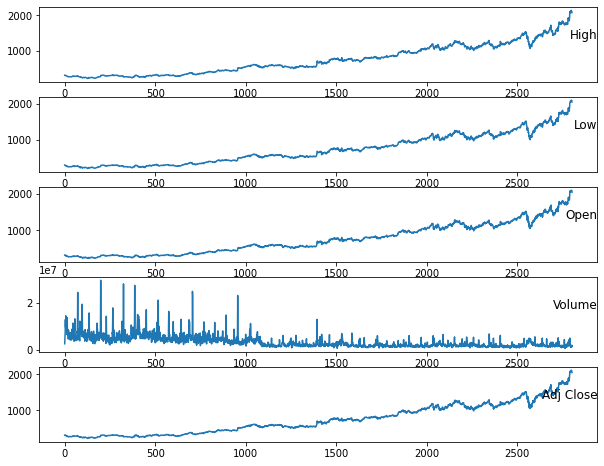

In [209]:
from matplotlib import pyplot
# load dataset
values = dataset.values
# specify columns to plot
groups = [0, 1, 2, 3, 4]
i = 1
# plot each column
pyplot.figure()
for group in groups:
    pyplot.subplot(len(groups), 1, i)
    pyplot.plot(values[:, group])
    pyplot.title(dataset.columns[group], y=0.5, loc='right')
    i += 1
pyplot.show()

In [210]:
from pandas import DataFrame
import pandas as pd

# function สำหรับ preprocess ข้อมูล time series หลายตัวแปร
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [211]:
values = dataset.values

# integer encode direction
values = values.astype('float32')

# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)

# # drop columns we don't want to predict
reframed.drop(reframed.columns[[0, 1, 2, 3]], axis=1, inplace=True)
print(reframed.head())

   var5(t-1)   var1(t)   var2(t)   var3(t)   var4(t)   var5(t)
1   0.048436  0.048711  0.050845  0.049997  0.118092  0.050219
2   0.050219  0.048276  0.050125  0.050058  0.189947  0.049493
3   0.049493  0.047761  0.046076  0.049708  0.256697  0.045350
4   0.045350  0.043635  0.042418  0.045345  0.423613  0.041620
5   0.041620  0.041879  0.041474  0.040734  0.307795  0.043706


In [212]:
# split into train and test sets
values = reframed.values
train = values[:int(len(values)*0.8), :]
test = values[int(len(values)*0.8):, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(2242, 1, 5) (2242,) (561, 1, 5) (561,)


In [213]:
# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=100, batch_size=64, validation_data=(test_X, test_y), verbose=2, shuffle=False)

Epoch 1/100
36/36 - 0s - loss: 0.0842 - val_loss: 0.1961
Epoch 2/100
36/36 - 0s - loss: 0.0814 - val_loss: 0.0947
Epoch 3/100
36/36 - 0s - loss: 0.0588 - val_loss: 0.0116
Epoch 4/100
36/36 - 0s - loss: 0.0362 - val_loss: 0.0248
Epoch 5/100
36/36 - 0s - loss: 0.0065 - val_loss: 0.0129
Epoch 6/100
36/36 - 0s - loss: 0.0054 - val_loss: 0.0115
Epoch 7/100
36/36 - 0s - loss: 0.0049 - val_loss: 0.0096
Epoch 8/100
36/36 - 0s - loss: 0.0072 - val_loss: 0.0111
Epoch 9/100
36/36 - 0s - loss: 0.0072 - val_loss: 0.0103
Epoch 10/100
36/36 - 0s - loss: 0.0066 - val_loss: 0.0087
Epoch 11/100
36/36 - 0s - loss: 0.0077 - val_loss: 0.0108
Epoch 12/100
36/36 - 0s - loss: 0.0091 - val_loss: 0.0141
Epoch 13/100
36/36 - 0s - loss: 0.0044 - val_loss: 0.0112
Epoch 14/100
36/36 - 0s - loss: 0.0035 - val_loss: 0.0101
Epoch 15/100
36/36 - 0s - loss: 0.0034 - val_loss: 0.0097
Epoch 16/100
36/36 - 0s - loss: 0.0049 - val_loss: 0.0099
Epoch 17/100
36/36 - 0s - loss: 0.0041 - val_loss: 0.0084
Epoch 18/100
36/36 - 0s

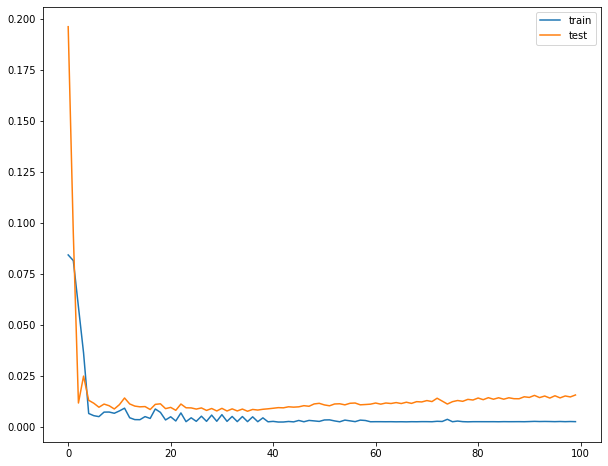

In [214]:
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

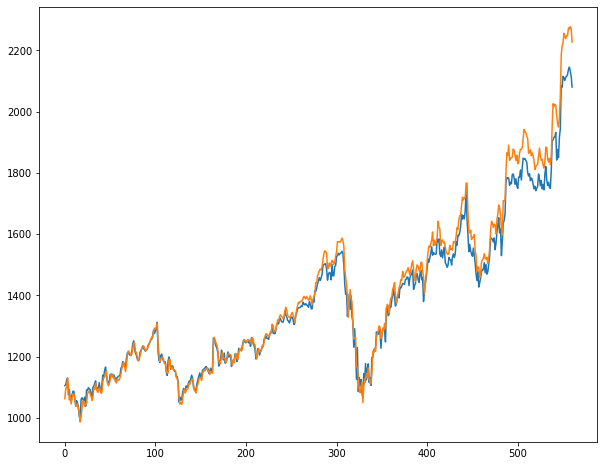

In [215]:
# Make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# Invert scaling for forecast
inv_yhat = np.concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# Invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

# Calculate RMSE
rmse = math.sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

plt.plot(inv_y)
plt.plot(inv_yhat)
plt.show()
# print(inv_y)
# print(inv_yhat)

In [216]:
import math
from tensorflow.keras.models import load_model
model.save('my_model.h5')
model = load_model('my_model.h5')
from sklearn.metrics import r2_score
#trainScore = math.sqrt(r2_score(test_y[0],  yhat[:,0]))
#print('Train Score: %.2f R2' % (trainScore))
testScore = math.sqrt(r2_score(inv_y, inv_yhat))
print('Test Score: %.2f R2' % (testScore))

Test Score: 0.98 R2
